# IMG_4485

- **findContours⇨ contours, hierarchy**

<div align='left'><img src="contour_explain.png" width="50%"></div>

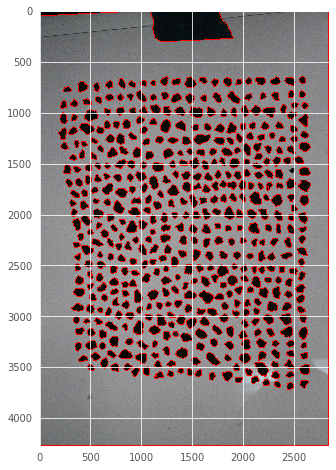

In [19]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 17 17:38:06 2020

@author: sayaka71
"""

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


# グラフ描画の関数定義
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

# グレー画像
img = cv2.imread('IMG_4485.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


# 大津法で2値化 retはbool値
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# ノイズを消す
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 5)

# 確実な背景
sure_bg = cv2.dilate(opening,kernel,iterations=5)

# --- 距離変換　（オブジェクトと背景の距離を出す） ---
# 閾値（距離変換で得られた値の最大値×0.2） ←ここを調節！
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.08*dist_transform.max(), 255, 0)

# 距離変換の結果から確実な前景を
sure_fg = np.uint8(sure_fg)

# 前景でも後景でもないUnknown
unknown = cv2.subtract(sure_bg,sure_fg)


# オブジェクトごとにラベルをつける
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

# markersデータをもとにwatershed
markers = cv2.watershed(img, markers)

# contours(輪郭), hierarchy(階層，親子)
contours, hierarchy = cv2.findContours(markers.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    
    if hierarchy[0][i][3] == -1:
        # 境界を赤色で描く  (255, 0,　0)： color red,  5pt line
        cv2.drawContours(img, contours, i, (255, 0, 0), 5)
        
display(img)

In [20]:
len(contours)

971

In [21]:
# 外れ値をdelete（あとで外れ値がわかるけど先に削除しとく）
# contours = np.delete(contours, 1678,0)
contours = np.delete(contours, -1,0)
contours = np.delete(contours, 969,0)
contours = np.delete(contours, 968,0)

OpenCV公式サイト⇨ [Moment](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html)

In [22]:
from math import sqrt, pi ,acos
from tqdm import tqdm
from scipy.spatial import distance

# 粒子の形状を測定
Areas = []
Perimeters = []
Circularities = []
Eq_diameters = []
Longest = []
Shortest = []
Distance_Gomez = []
degrees = np.arange(0, 2*pi, 2*pi/36) # degrees: 10度ずつで回す (2pi/36 = 10deg)

for cnt in tqdm(contours):
    # 面積 (px*px)
    area = cv2.contourArea(cnt)
    Areas.append(area)
    
    # 周囲長(perimeter)
    arc = cv2.arcLength(cnt, True)
    Perimeters.append(arc)
    # 円形度(circularity)
    circularity = 4 * np.pi * area/(arc*arc)
    Circularities.append(circularity)
    
    # 等価直径(px)
    eq_diameter = np.sqrt(4 * area/np.pi)
    Eq_diameters.append(eq_diameter)
    
    # 重心(Moment)
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    # 重心から輪郭までの距離 (Distance_Gomez)
    for deg in degrees:
        for cnts in cnt:
            # cntの(x,y)座標
            x = cnts[0,0]
            y = cnts[0,1]
            # ユークリッド距離
            d_eu = distance.euclidean((x,y), (cx,cy))
            # 指定角度の方向にある輪郭の点を求める誤差1度まで ( |acos(x-cx) / d_eu| < 1 degree )
            if abs(acos((x-cx)/d_eu) - deg) < pi/360:
                break
            else:
                continue
        # scaling
        d_eu_scaled = d_eu/eq_diameter
        Distance_Gomez.append(d_eu_scaled)
    # Ellipse - shortest, longest ax
    ellipse = cv2.fitEllipse(cnt)
    Shortest.append(ellipse[1][0])
    Longest.append(ellipse[1][1])
            
        

100%|██████████| 968/968 [01:18<00:00, 12.33it/s]


36.0
n = 5.0


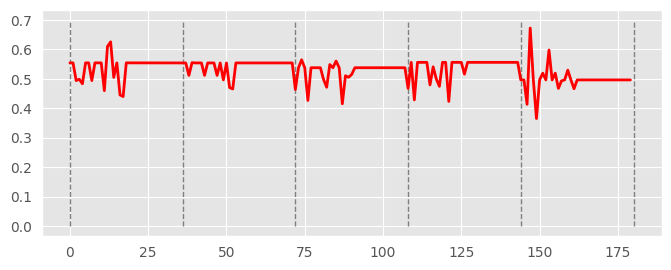

In [23]:
# plot distance (n=5)
print(len(Distance_Gomez)/len(contours))
print(f'n = {len(Distance_Gomez[:180])/36}')

# plot
plt.figure(figsize=(8,3), dpi=100)
plt.plot(np.arange(len(Distance_Gomez[:180])), Distance_Gomez[:180], c='r', lw=2)
# 垂直線 vline
vline = np.arange(0, 181, 36)
for i in vline:
    plt.vlines([i], 0, 0.7, 'gray', linestyle='dashed', lw=1)

Text(0.5, 1.0, 'Distance (All)')

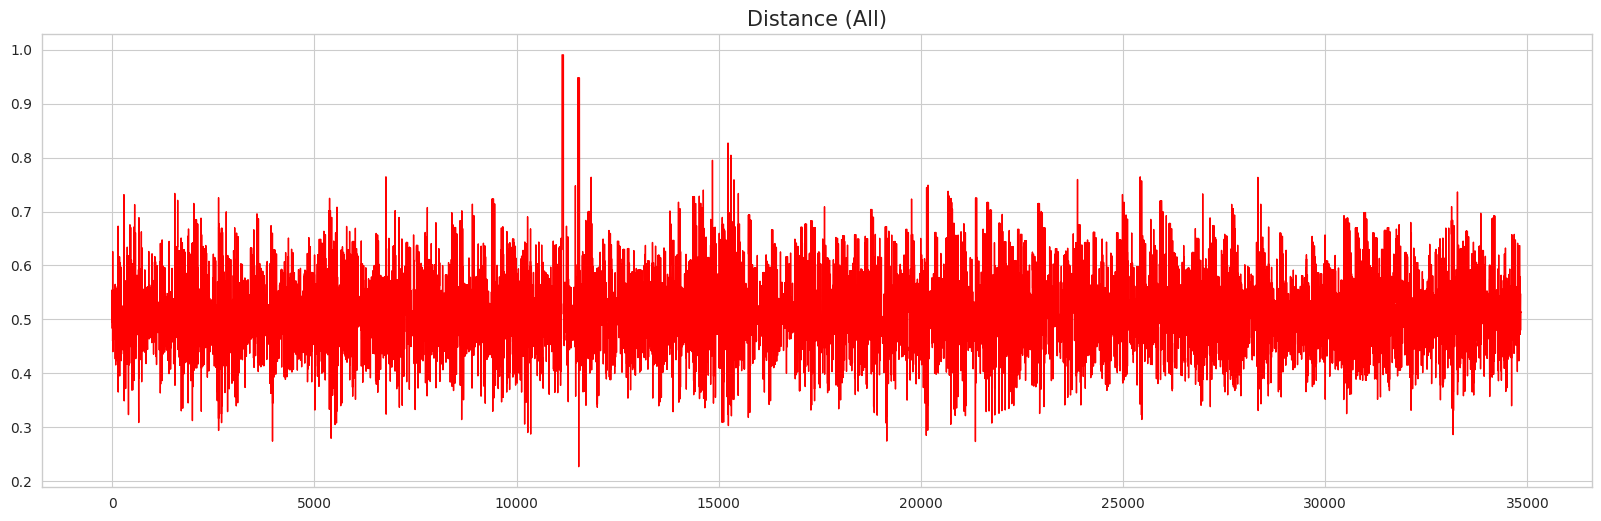

In [24]:
# Distance
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(20,6), dpi=100)
plt.plot(np.arange(len(Distance_Gomez)), Distance_Gomez, c='r', lw=1)
plt.title('Distance (All)', {'fontsize':15})

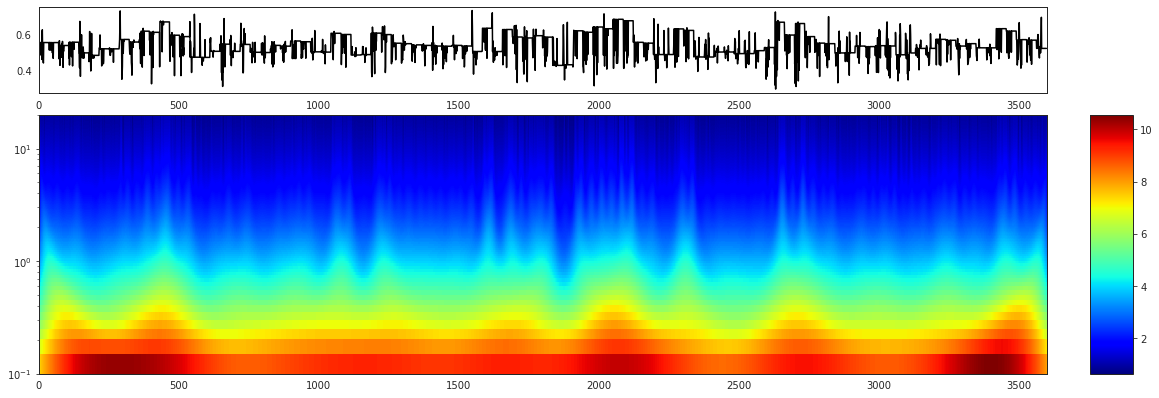

In [25]:
# morlet wavelet n=100 (n=3600/36), omega=0.2

sns.set_style('white')
from swan import pycwt
x = np.arange(len(Distance_Gomez[:3600]))
y = Distance_Gomez[:3600]
              
Fs = 1/0.01
omega0 = 0.2

# (1)　Freqを指定してcwt
freqs=np.arange(0.1,10,0.025)
r=pycwt.cwt_f(y,freqs,Fs,pycwt.Morlet(omega0))
rr=np.abs(r)


plt.rcParams['figure.figsize'] = (20, 6)
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2])
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

ax1.plot(x, y, 'k')

img = ax2.imshow(np.flipud(rr), extent=[0, 3600,0.1, 20], aspect='auto', cmap='jet') 
twin_ax = ax2
twin_ax.set_yscale('log')
twin_ax.set_xlim(0, 3600)
twin_ax.set_ylim(0.1, 20)
ax2.tick_params(which='both', labelleft=False, left=False)
twin_ax.tick_params(which='both', labelleft=True, left=True, labelright=False)
fig.colorbar(img, cax=ax3)
plt.show()

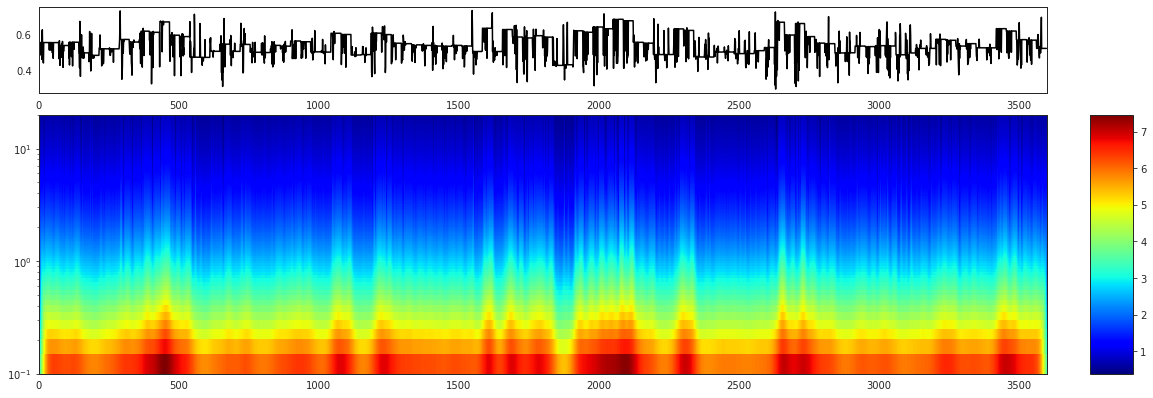

In [26]:
# morlet wavelet n=100 (n=3600/36), omega=0.02

sns.set_style('white')
from swan import pycwt
x = np.arange(len(Distance_Gomez[:3600]))
y = Distance_Gomez[:3600]
              
Fs = 1/0.01
omega0 = 0.02

# (1)　Freqを指定してcwt
freqs=np.arange(0.1,10,0.025)
r=pycwt.cwt_f(y,freqs,Fs,pycwt.Morlet(omega0))
rr=np.abs(r)


plt.rcParams['figure.figsize'] = (20, 6)
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2])
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

ax1.plot(x, y, 'k')

img = ax2.imshow(np.flipud(rr), extent=[0, 3600,0.1, 20], aspect='auto', cmap='jet') 
twin_ax = ax2
twin_ax.set_yscale('log')
twin_ax.set_xlim(0, 3600)
twin_ax.set_ylim(0.1, 20)
ax2.tick_params(which='both', labelleft=False, left=False)
twin_ax.tick_params(which='both', labelleft=True, left=True, labelright=False)
fig.colorbar(img, cax=ax3)
plt.show()

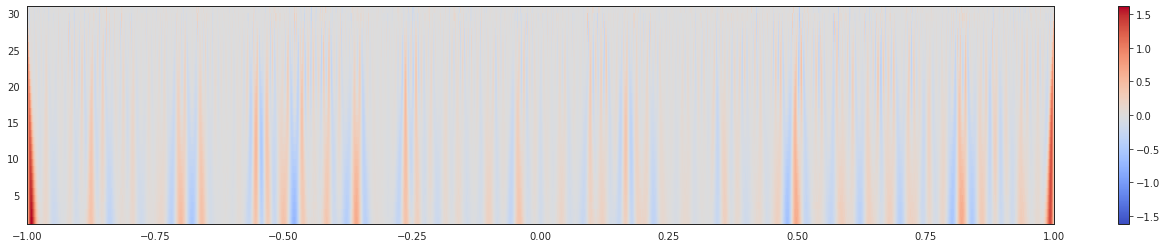

In [27]:
# wavenet n=200 (mexican hat👒)
import pywt
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(Distance_Gomez[:7200], widths, 'mexh')
sns.set_style('white')
plt.figure(figsize=(23, 4))
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='coolwarm', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  
plt.colorbar();

## DataFrame

In [28]:
import pandas as pd
df = pd.DataFrame({'Areas(px^2)': Areas, 'Circularity': Circularities, 'Equal Diameters(px)': Eq_diameters, 'Shortest Axis(px)': Shortest, 'Longest Axis(px)': Longest, 'Perimeters(px)': Perimeters})

In [29]:
df.head()

,Areas(px^2),Circularity,Equal Diameters(px),Shortest Axis(px),Longest Axis(px),Perimeters(px)
0,3282.0,0.772936,64.643423,60.356750,73.488350,230.994947
1,3694.0,0.790622,68.580951,63.726017,76.986046,242.308656
2,2662.0,0.792278,58.218242,50.919910,67.359329,205.480229
3,3018.0,0.806928,61.989007,54.219162,71.325768,216.793937
4,4058.0,0.652471,71.880499,69.126724,82.447632,279.563489


In [30]:
# 外れ値
# df.loc[df['Longest Length(px)'] > 700]
# >>> 1678, 1341
# df.loc[df['Perimeters(px)'] > 1000]

In [31]:
# df.loc[df['Circularity'] < 0.6]

In [32]:
# df.drop(1678,axis=0, inplace=True)
# df.drop(1341,axis=0, inplace=True)
# df.drop([32,33,66,67,76,78,130,131,132,133], inplace=True)
# df.drop([968,969],axis=0, inplace=True)

In [33]:
df.describe()

,Areas(px^2),Circularity,Equal Diameters(px),Shortest Axis(px),Longest Axis(px),Perimeters(px)
count,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000
mean,4483.009298,0.739313,74.043404,65.960143,87.579139,271.049716
std,1886.865243,0.051917,15.025056,13.591798,20.052268,56.747980
min,4.000000,0.269506,2.256758,7.211102,7.211102,13.656854
25%,3180.375000,0.713344,63.634732,56.620282,73.457632,230.919569
50%,3903.750000,0.747730,70.501126,63.307178,82.829128,257.764499
75%,5281.625000,0.772691,82.004699,72.873383,99.932352,302.871101
max,12096.000000,0.844167,124.101191,111.615166,169.492432,475.587874


sample number = 968



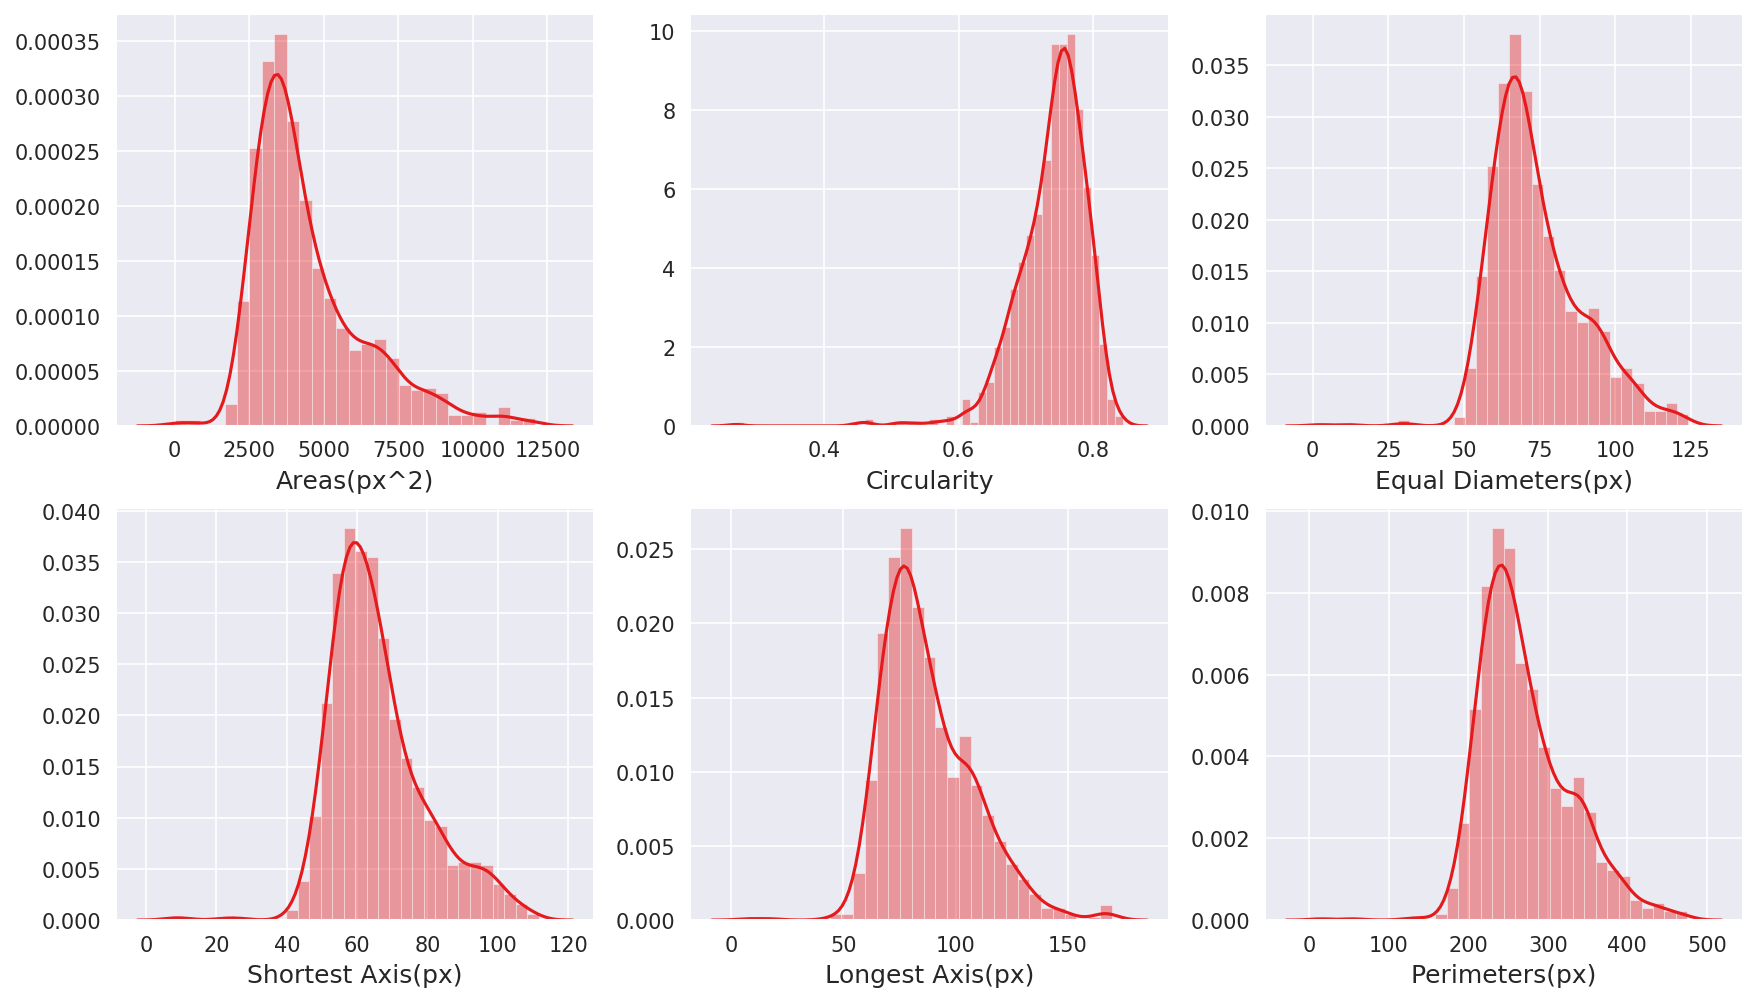

In [34]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set1')
print('sample number = {}\n'.format(len(contours)))
fig, ax = plt.subplots(2,3,figsize=(14,8), dpi=150)

sns.distplot(df['Areas(px^2)'], ax=ax[0,0])
sns.distplot(df['Circularity'], ax=ax[0,1])
sns.distplot(df['Equal Diameters(px)'], ax=ax[0,2])
sns.distplot(df['Shortest Axis(px)'], ax=ax[1,0])
sns.distplot(df['Longest Axis(px)'], ax=ax[1,1])
sns.distplot(df['Perimeters(px)'], ax=ax[1,2]);

# 確率分布
![distribution](Distribution.png)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)


Text(0, 0.5, '')

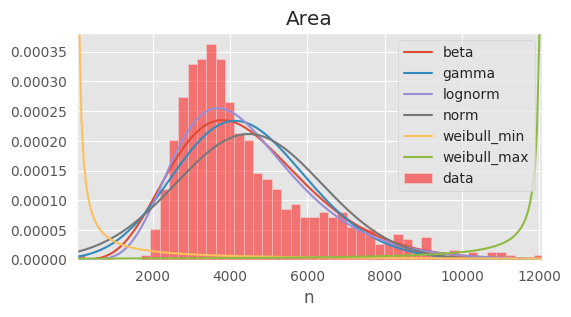

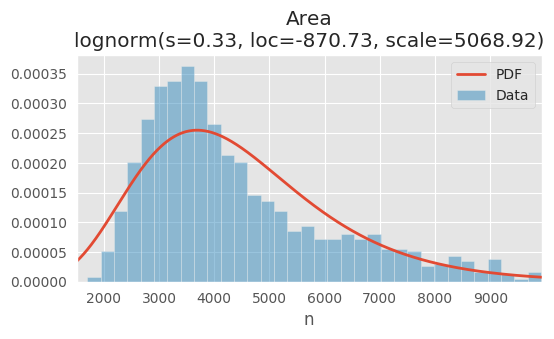

In [35]:
# scriptの更新を反映するおまじない
%load_ext autoreload
%autoreload 2

from functions.pdf import best_fit_distribution, make_pdf, find_PDF

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib


matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Load data from statsmodels datasets
data = pd.Series(Areas)

# Plot for comparison
plt.figure(figsize=(6,3), dpi=100)
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='data', legend=True, color='red')
ax.legend(loc='upper right')

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Area')
ax.set_xlabel(u'n')
ax.set_ylabel('')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(6,3), dpi=100)
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Area\n' + dist_str)
ax.set_xlabel(u'n')
ax.set_ylabel('')


In [36]:
# Probability Density Functionをそれぞれ見つける
data_all = [Areas, Circularities, Eq_diameters, Shortest, Longest, Perimeters]
data_name = ['Areas', 'Circularities', 'Eq_diameters', 'Shortest', 'Longest', 'Perimeters']
find_PDF(data_all, data_name)

Areas: lognorm(s=0.33, loc=-870.73, scale=5068.92)
Circularities: weibull_min(c=121261479.61, loc=-4735726.15, scale=4735726.91)
Eq_diameters: lognorm(s=0.10, loc=-70.77, scale=144.06)
Shortest: lognorm(s=0.12, loc=-46.73, scale=111.89)
Longest: lognorm(s=0.15, loc=-40.25, scale=126.33)
Perimeters: gamma(a=47.01, loc=-112.30, scale=8.15)
